In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
ds1tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-fan-test.npy')
ds2tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-pump-test.npy')
ds3tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-slider-test.npy')
ds4tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-ToyCar-test.npy')
ds5tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-ToyConveyor-test.npy')
ds6tt = np.load(r'C:\Users\14124\Desktop\Capstone\archive\dc2020t2l1-valve-test.npy')

In [3]:
newds4tt = ds4tt[:, :, :313]

data = np.concatenate((ds1tt, ds2tt, ds3tt, newds4tt, ds5tt, ds6tt))

In [4]:
mfccData = librosa.feature.mfcc(S = data)

stdDevMfccs = np.std(mfccData, axis = 2)

meanMfccs = np.mean(mfccData, axis = 2)

averageDifference = np.zeros((20, 10868))
for i in range(0, len(mfccData.T) - 2, 2):
    averageDifference += mfccData.T[i] - mfccData.T[i+1]

averageDifference /= (len(mfccData) // 2)
averageDifference = np.array(averageDifference.T)

concatFeatures = np.hstack((stdDevMfccs, meanMfccs))
concatFeatures = np.hstack((concatFeatures, averageDifference))
mfccDataFeatures = concatFeatures

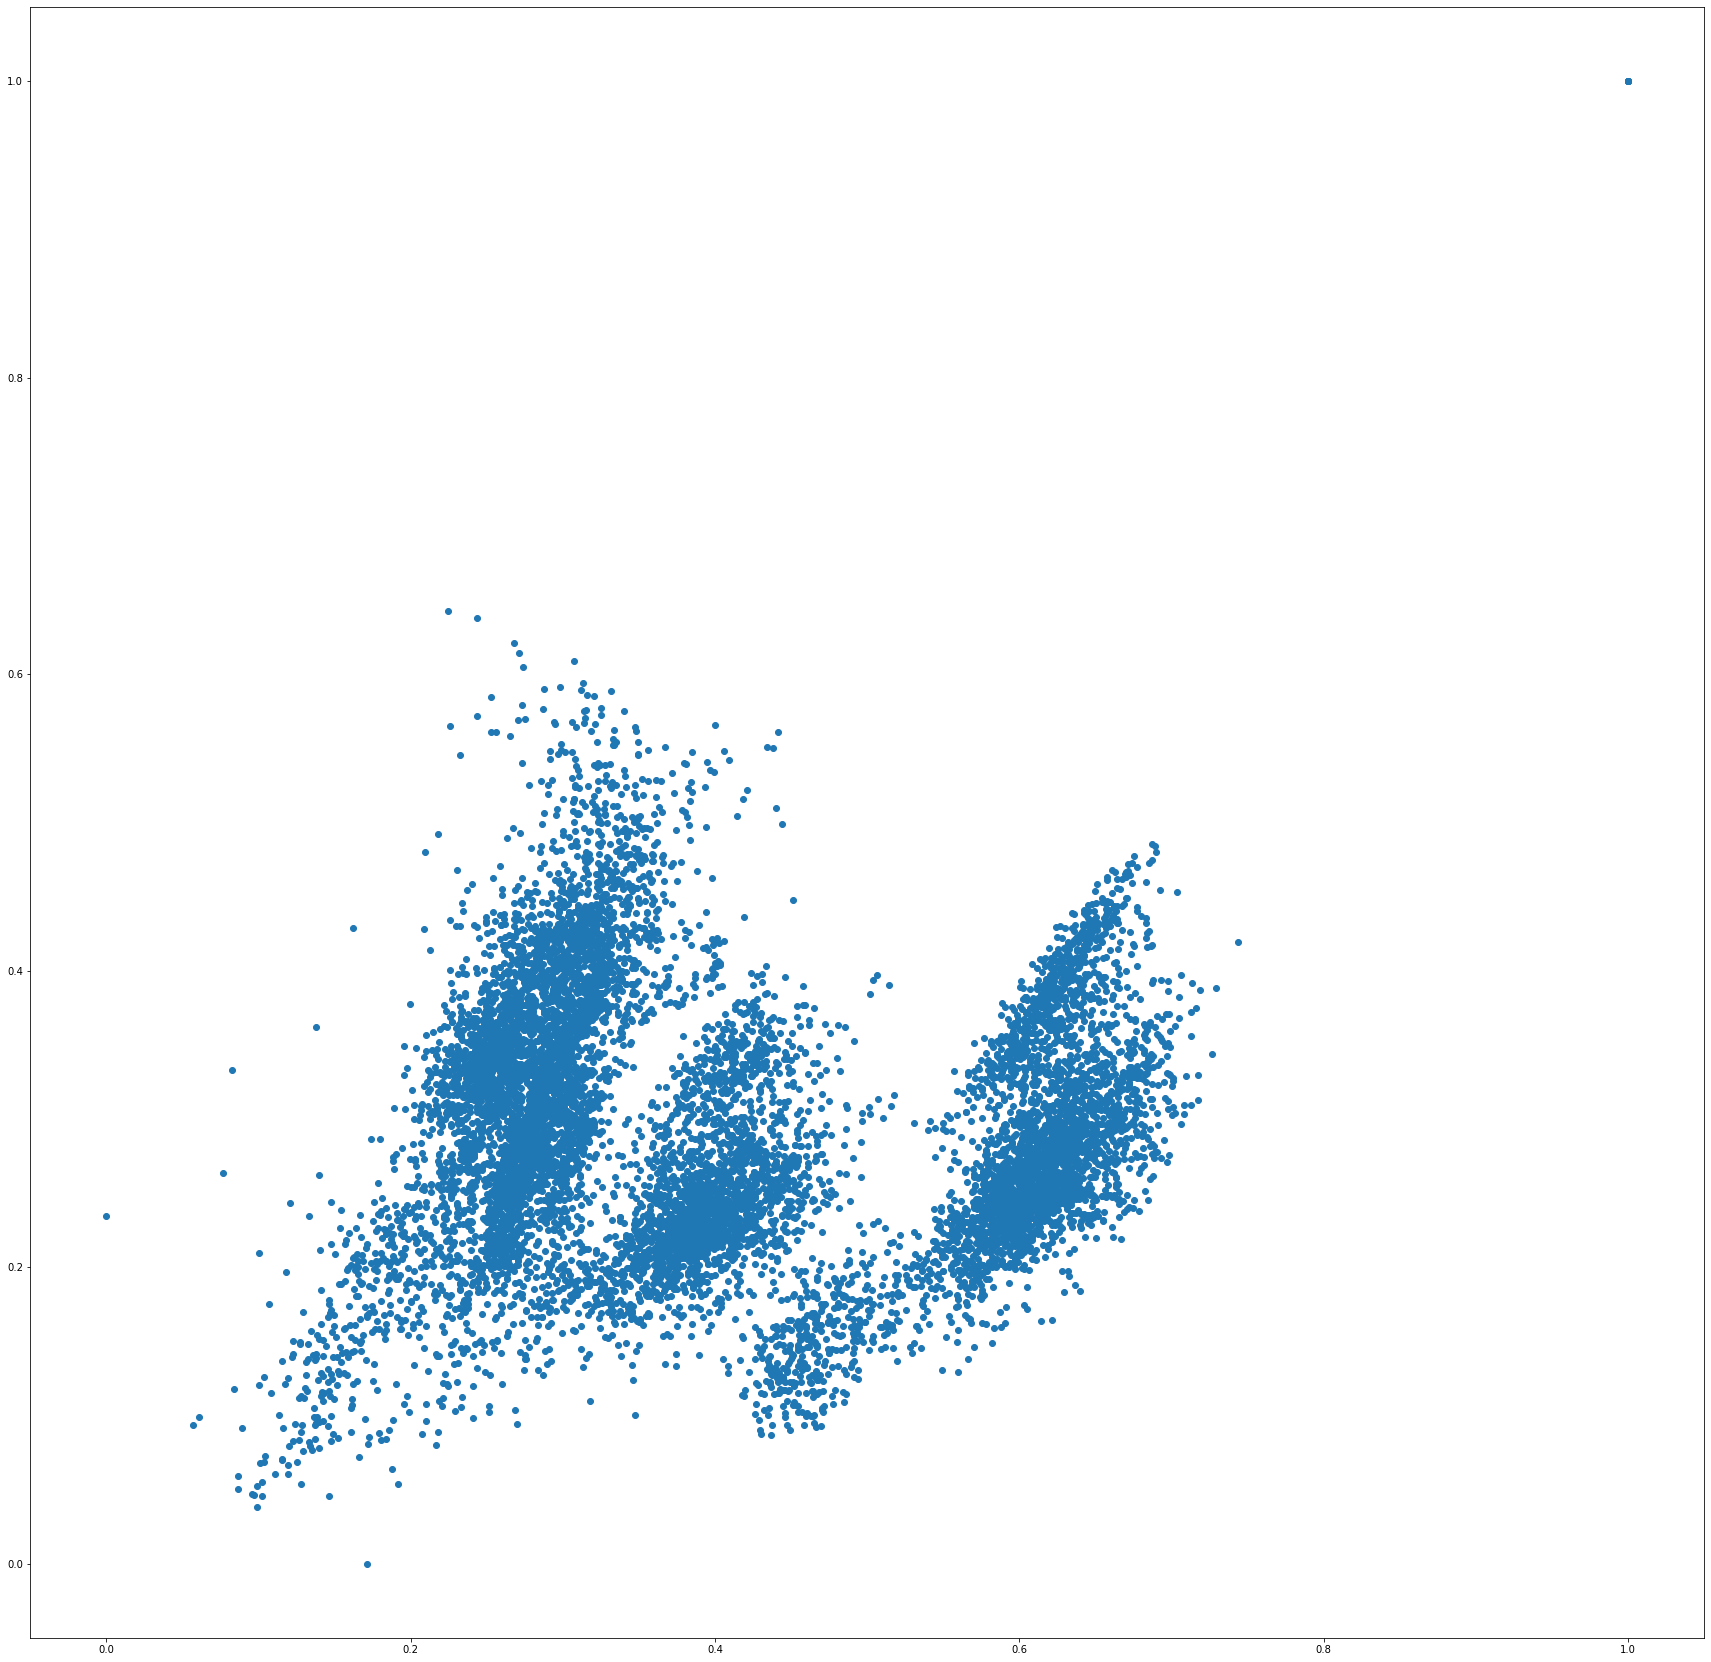

In [5]:
def getPCA(features):
    pca = PCA(n_components=2)
    transformed = pca.fit(features).transform(features)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed)

pcaMfccData = getPCA(mfccDataFeatures)

plt.figure(figsize=(30, 30))
pcaData = plt.scatter(pcaMfccData.T[0],pcaMfccData.T[1])
plt.show()

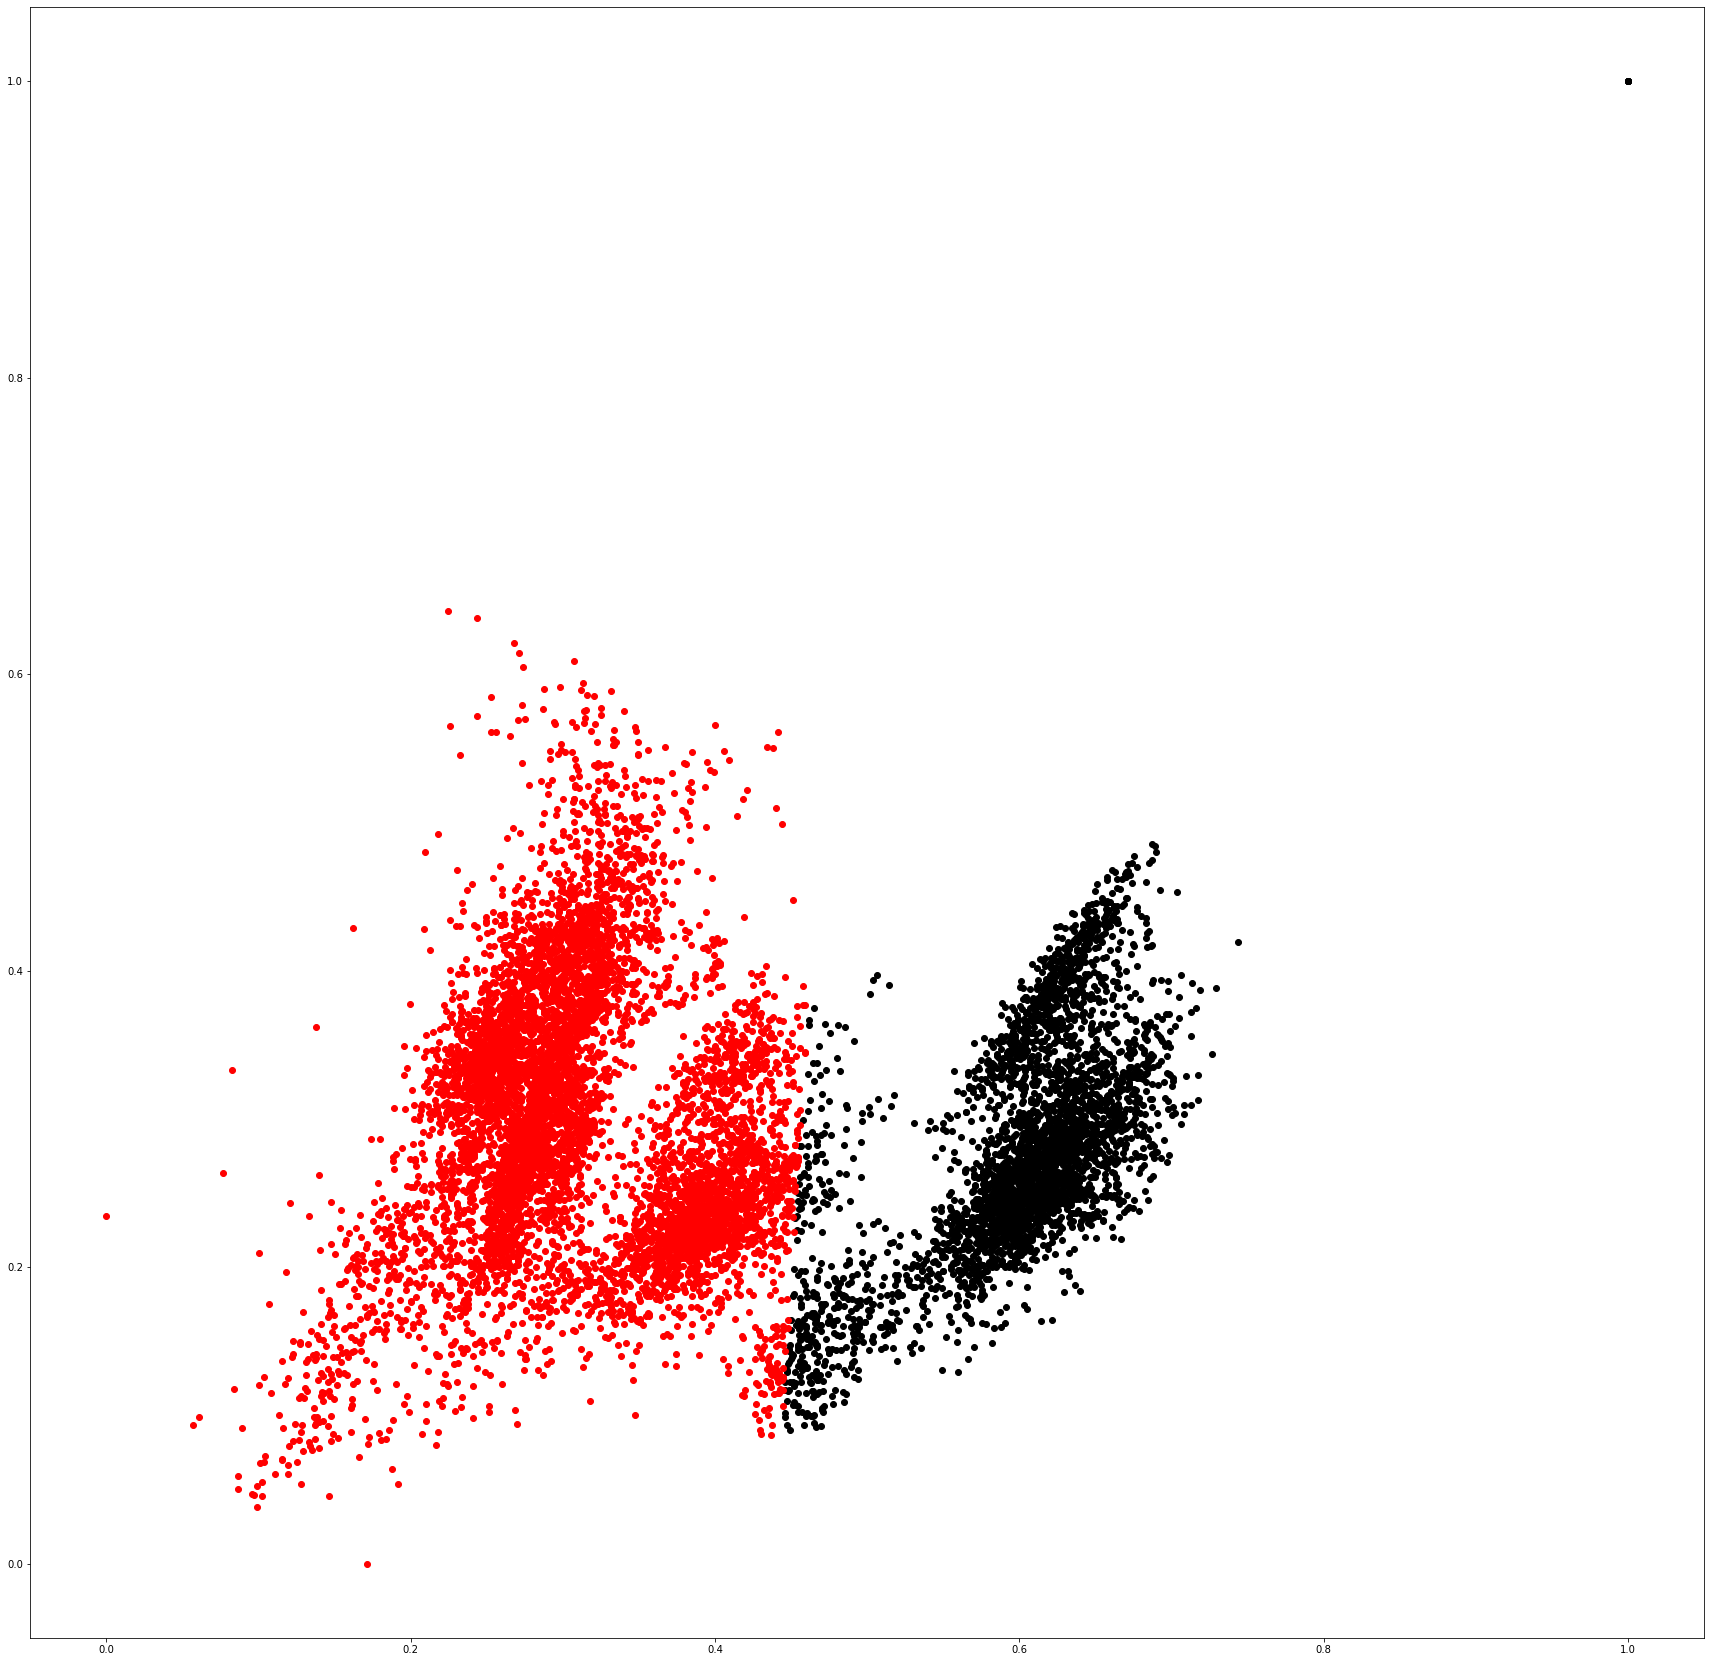

In [6]:
kmeans = KMeans(n_clusters=2, init='k-means++')
label = kmeans.fit_predict(pcaMfccData)
filtered1 = pcaMfccData[label == 0]
filtered2 = pcaMfccData[label == 1]
plt.figure(figsize=(30, 30))
plt.scatter(filtered1[:,0], filtered1[:,1], c = 'black')
plt.scatter(filtered2[:,0], filtered2[:,1], c = 'red')
plt.show()

In [7]:
clusters = pd.DataFrame(pcaMfccData)
labels = kmeans.labels_
aCluster = clusters[labels == 1]
aDataIndex = aCluster.index.values
aData = data[aDataIndex]

nCluster = clusters[labels == 0]
nDataIndex = nCluster.index.values
nData = data[nDataIndex]


In [8]:
normalTrain, normalTest = train_test_split(nData, train_size = .75, random_state = 9)
anomLeftover, anomTest = train_test_split(aData, train_size = .50, random_state = 9)

In [9]:
test = tf.concat([normalTest, anomTest], axis = 0)

mfccTrain = librosa.feature.mfcc(S = normalTrain)
mfccVal = librosa.feature.mfcc(S = normalTest)
mfccTest = librosa.feature.mfcc(S = test)

mfccTrain = mfccTrain[..., tf.newaxis]
mfccVal = mfccVal[..., tf.newaxis]
mfccTest = mfccTest[..., tf.newaxis]

normalRows =  mfccTrain.shape[1]
normalColumns = mfccTrain.shape[2]
normalVRows = mfccVal.shape[1]
normalVCols = mfccVal.shape[2]
testRows = mfccTest.shape[1]
testCols = mfccTest.shape[2]

rowsNeeded = abs((normalRows%4)-4)%4
columnsNeeded = abs((normalColumns%4)-4)%4
vRowsNeeded = abs((normalVRows%4)-4)%4
vColsNeeded = abs((normalVCols%4)-4)%4
testRowsNeeded = abs((testRows%4)-4)%4
testColsNeeded = abs((testCols%4)-4)%4

mfccTrain = tf.keras.layers.ZeroPadding2D(padding=((rowsNeeded,0),(columnsNeeded,0)))(mfccTrain)
mfccVal = tf.keras.layers.ZeroPadding2D(padding=((vRowsNeeded,0),(vColsNeeded,0)))(mfccVal)
mfccTest = tf.keras.layers.ZeroPadding2D(padding=((testRowsNeeded,0),(testColsNeeded,0)))(mfccTest)

x_train = mfccTrain
x_val = mfccVal
x_test = mfccTest

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_9708/41383232.py, line 2)

In [ ]:
encoder = tf.keras.models.Sequential()
encoder.add(tf.keras.layers.Conv2D(32, 3, padding = "same", activation = "relu", input_shape = x_train.shape[1:]))
encoder.add(tf.keras.layers.MaxPooling2D())
encoder.add(tf.keras.layers.Conv2D(64, 3, padding = "same", activation = "relu"))
encoder.add(tf.keras.layers.MaxPooling2D())
encoder.summary()

decoder = tf.keras.models.Sequential()
decoder.add(tf.keras.layers.Conv2D(32, 3, padding = "same", activation = "relu", input_shape = encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())
decoder.add(tf.keras.layers.Conv2D(16, 3, padding = "same", activation = "relu", input_shape = encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())
decoder.add(tf.keras.layers.Conv2D(1, 3, padding = "same", activation = "relu", input_shape=encoder.output.shape[1:]))
decoder.summary()

CAE = tf.keras.Model(inputs = encoder.input, outputs = decoder(encoder.outputs))
CAE.compile(optimizer = tf.keras.Adam(), los = tf.keras.losses.MeanSquaredError)
CAE.summary

history = CAE.fit(x_train, x_train, validation_data = (x_val, x_val), epochs=50)

In [ ]:
mfccATest = librosa.feature.mfcc(S = anomTest)
mfccATest = mfccATest[..., tf.newaxis]
testARows = mfccATest.shape[1]
testACols = mfccATest.shape[2]
testARowsNeeded = abs((testARows%4)-4)%4
testAColsNeeded = abs((testACols%4)-4)%4
mfccATest = tf.keras.layers.ZeroPadding2D(padding=((testARowsNeeded,0),(testAColsNeeded,0)))(mfccATest)

anomGroundTruths = tf.constant(True, shape = len(mfccATest, dtype = bool))
normalGroundTruths = tf.constant(False, shape = len(mfccVal), dtype = bool)
groundTruths = tf.concat([normalGroundTruths, anomGroundTruths], axis=0)

startInference = time.time()
testReconstructions = CAE.predict(x_test)
inferenceTime = time.time()-startInference


